In [1]:
from datasets import load_dataset

dataset = load_dataset("teknium/trismegistus-project")
dataset

DatasetDict({
    train: Dataset({
        features: ['topic', 'domain_task_type', 'id', 'system_prompt_used', 'source', 'conversations'],
        num_rows: 13528
    })
})

In [2]:
# convert the dataset to pandas dataframe
import pandas as pd

df = pd.DataFrame(dataset["train"])
df.head()

,topic,domain_task_type,id,system_prompt_used,source,conversations
0,'Big Man' society,Task,570a8404-3270-4aba-a47c-660359440835,"You are a master of the esoteric, occult, 'Big...",DomainExpert_Occult,"[{'from': 'human', 'value': 'Compose a compreh..."
1,'Big Man' society,Task,ddf44765-8756-46db-a945-672050905fc0,"You are a master of the esoteric, occult, 'Big...",DomainExpert_Occult,"[{'from': 'human', 'value': 'Develop an intric..."
2,'Big Man' society,Task,9ef38c3a-31ed-48d7-94d2-75fc588bcb2e,"You are a master of the esoteric, occult, 'Big...",DomainExpert_Occult,"[{'from': 'human', 'value': 'Write an extensiv..."
3,'Big Man' society,Task,6dea7781-0f74-4692-8d1d-762c6585c280,"You are a master of the esoteric, occult, 'Big...",DomainExpert_Occult,"[{'from': 'human', 'value': 'Develop an intric..."
4,'Black Books' of European necromancy,Task,188c6c15-d2b7-448b-b93c-505aeca2a458,"You are a master of the esoteric, occult, 'Bla...",DomainExpert_Occult,"[{'from': 'human', 'value': 'Devise an intrica..."


In [3]:
# Split the quetion and answer into separate columns
df[["question", "answer"]] = pd.DataFrame(df["conversations"].tolist(), index=df.index)

# Only keep the 'value' portion of the JSON
df["question"] = df["question"].apply(lambda x: x["value"])
df["answer"] = df["answer"].apply(lambda x: x["value"])

df[["system_prompt_used", "question", "answer"]]

,system_prompt_used,question,answer
0,"You are a master of the esoteric, occult, 'Big...",Compose a comprehensive biography of a renowne...,Title: The Mystifying Odyssey of Eliphas Black...
1,"You are a master of the esoteric, occult, 'Big...",Develop an intricate numerology system that de...,I. Foundational Numerology\n\nThe 'Big Man' so...
2,"You are a master of the esoteric, occult, 'Big...",Write an extensive biography of a prominent oc...,Title: Nathaniel Ziester: A Life in Shadows - ...
3,"You are a master of the esoteric, occult, 'Big...","Develop an intricate system of numerology, inc...",Title: The Numerological Riddles of the Big Ma...
4,"You are a master of the esoteric, occult, 'Bla...",Devise an intricate multi-step process for the...,Step 1: Assess the condition of the grimoire\n...
...,...,...,...
13523,"You are a master of the esoteric, occult, Reap...",In the context of the Reappropriated Goddess m...,Answer: To regain women's empowerment and infl...
13524,"You are a master of the esoteric, occult, Reap...",Write a section of a grimoire explaining the c...,Title: The Reappropriated Goddess in the Occul...
13525,"You are a master of the esoteric, occult, Reap...",Write a section of a grimoire specifically foc...,Title: The Reappropriated Goddess: A Journey i...
13526,"You are a master of the esoteric, occult, Reap...",Create a detailed introductory section for a g...,Title: The Reappropriated Goddess: A Grimoire ...


In [4]:
def generate_prompt(row: pd.Series) -> str:
    "Format to Llama's chat template"
    return """<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n## Instructions
{}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n
## User
{}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n
{}""".format(row["system_prompt_used"], row["question"], row["answer"])


df["text"] = df.apply(generate_prompt, axis=1)

# Let's see what the model will be trained on
print(df["text"].iloc[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

## Instructions
You are a master of the esoteric, occult, 'Big Man' society, you complete tasks to the absolute best of your ability, no matter if you think you were not trained to do the task specifically, you will attempt to do it anyways, since you have performed the tasks you are given with great mastery, accuracy, and deep understanding of what is requested. You do the tasks faithfully, and stay true to the mode and domain's mastery role. If the task is not specific enough, note that and create specifics that enable completing the task.<|eot_id|><|start_header_id|>user<|end_header_id|>


## User
Compose a comprehensive biography of a renowned figure in the 'Big Man' society, delving into their connections to the occult and esoteric realms. Emphasize their influence on the contemporary 'Big Man' society, their mystical practices, and the transmission of arcane knowledge. Ensure to explore the convergence of their occult w

In [6]:
from pathlib import Path

Path("llama-test-data").mkdir(exist_ok=True)

split_ix = int(len(df) * 0.9)
# shuffle data
data = df.sample(frac=1, random_state=42)
train, valid = data[:split_ix], data[split_ix:]

# Save train and valid dataset as jsonl files
train[["text"]].to_json("llama-test-data/train.jsonl", orient="records", lines=True, force_ascii=False)
valid[["text"]].to_json("llama-test-data/valid.jsonl", orient="records", lines=True, force_ascii=False)

!head -n 1 llama-test-data/train.jsonl

{"text":"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n## Instructions\nYou are a master of the esoteric, occult, Chronotopic inversion and education, you have written many textbooks on the subject in ways that provide students with rich and deep understanding of the subject. You are being asked to write textbook-like sections on a topic and you do it with full context, explainability, and reliability in accuracy to the true facts of the topic at hand, in a textbook style that a student would easily be able to learn from, in a rich, engaging, and contextual way. Always include relevant context (such as formulas and history), related concepts, and in a way that someone can gain deep insights from.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n\n## User\nWrite a detailed explanation of Chronotopic inversion within the context of the occult, focusing on its history, methodology, practical applications, and key concepts. Elaborate on how an adept in the esoteric art

In [7]:
train_set = []

In [8]:
with open('llama-test-data/train.jsonl', 'r') as json_file:
    json_list = list(json_file)

In [9]:
import json
for rec in json_list:
    train_set.append(json.loads(rec)["text"])

In [10]:
train_set[0:3]

["<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n## Instructions\nYou are a master of the esoteric, occult, Chronotopic inversion and education, you have written many textbooks on the subject in ways that provide students with rich and deep understanding of the subject. You are being asked to write textbook-like sections on a topic and you do it with full context, explainability, and reliability in accuracy to the true facts of the topic at hand, in a textbook style that a student would easily be able to learn from, in a rich, engaging, and contextual way. Always include relevant context (such as formulas and history), related concepts, and in a way that someone can gain deep insights from.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n\n## User\nWrite a detailed explanation of Chronotopic inversion within the context of the occult, focusing on its history, methodology, practical applications, and key concepts. Elaborate on how an adept in the esoteric arts can h

In [11]:
valid_set = []

In [12]:
with open('llama-test-data/valid.jsonl', 'r') as json_file:
    json_valid_list = list(json_file)

In [13]:
for rec in json_valid_list:
    valid_set.append(json.loads(rec)["text"])

In [14]:
valid_set[0:3]

['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n## Instructions\nYou are an expert in the field of the esoteric, occult, Supernatural beings and Education. You are a writer of tests, challenges, books and deep knowledge on Supernatural beings for initiates and students to gain deep insights and understanding from. You write answers to questions posed in long, explanatory ways and always explain the full context of your answer (i.e., related concepts, formulas, examples, or history), as well as the step-by-step thinking process you take to answer the challenges. Your answers to questions and challenges should be in an engaging but factual style, explain through the reasoning process, thorough, and should explain why other alternative answers would be wrong. Summarize the key themes, ideas, and conclusions at the end.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n\n## User\nConstruct a comprehensive cosmological hierarchy of supernatural beings, incorporating at l

In [15]:
import matplotlib.pyplot as plt
import mlx.core as mx
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm import load, generate
from mlx_lm.tuner import train, evaluate, TrainingArgs
from mlx_lm.tuner import linear_to_lora_layers
import tqdm
import json

In [16]:
# Make a directory to save the adapter config and weights
adapter_path = Path("adapters")
adapter_path.mkdir(parents=True, exist_ok=True)

lora_config = {
 "lora_layers": 8,
 "lora_parameters": {
    "rank": 8,
    "scale": 20.0,
    "dropout": 0.0,
}}

# Save the LoRA config to the adapter path
with open(adapter_path / "adapter_config.json", "w") as fid:
    json.dump(lora_config, fid, indent=4)    

training_args = TrainingArgs(
    adapter_file=adapter_path / "adapters.safetensors",
    iters=600,
    steps_per_eval=50
)

In [17]:
model_path = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model, tokenizer = load(model_path)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
# Freeze the base model
model.freeze()

# Convert linear layers to lora layers
linear_to_lora_layers(model, lora_config["lora_layers"], lora_config["lora_parameters"])

num_train_params = (
    sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
)
print(f"Number of trainable parameters: {num_train_params}")

Number of trainable parameters: 851968


In [19]:
# Put the model in training mode:
model.train()

# Make the optimizer:
opt = optim.Adam(learning_rate=1e-5)

# Make a class to record the training stats:
class Metrics:
    train_losses = []
    val_losses = []
    def on_train_loss_report(self, info):
        self.train_losses.append((info["iteration"], info["train_loss"]))
    def on_val_loss_report(self, info):
        self.val_losses.append((info["iteration"], info["val_loss"]))

metrics = Metrics()

# Train model:
train(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    optimizer=opt,
    train_dataset=train_set,
    val_dataset=valid_set,
    training_callback=metrics,
)

Starting training..., iters: 600
Iter 1: Val loss 2.026, Val took 146.664s
Iter 10: Train loss 1.940, Learning Rate 1.000e-05, It/sec 0.121, Tokens/sec 506.608, Trained Tokens 41827, Peak mem 39.839 GB
Iter 20: Train loss 1.711, Learning Rate 1.000e-05, It/sec 0.102, Tokens/sec 449.446, Trained Tokens 85956, Peak mem 49.346 GB
Iter 30: Train loss 1.770, Learning Rate 1.000e-05, It/sec 0.114, Tokens/sec 455.811, Trained Tokens 125793, Peak mem 49.346 GB
Iter 40: Train loss 1.818, Learning Rate 1.000e-05, It/sec 0.111, Tokens/sec 449.474, Trained Tokens 166307, Peak mem 49.346 GB
Iter 50: Val loss 1.740, Val took 165.632s
Iter 50: Train loss 1.762, Learning Rate 1.000e-05, It/sec 0.834, Tokens/sec 3396.821, Trained Tokens 207038, Peak mem 49.346 GB
Iter 60: Train loss 1.610, Learning Rate 1.000e-05, It/sec 0.109, Tokens/sec 449.067, Trained Tokens 248079, Peak mem 49.346 GB
Iter 70: Train loss 1.651, Learning Rate 1.000e-05, It/sec 0.113, Tokens/sec 421.224, Trained Tokens 285390, Peak m

In [20]:
system_prompt = df["system_prompt_used"].unique()[-2]
print(system_prompt)

You are a master in the field of the esoteric, occult, Reappropriated Goddess and Education. You are a writer of tests, challenges, books and deep knowledge on Reappropriated Goddess for initiates and students to gain deep insights and understanding from. You write answers to questions posed in long, explanatory ways and always explain the full context of your answer (i.e., related concepts, formulas, examples, or history), as well as the step-by-step thinking process you take to answer the challenges. Be rigorous and thorough, and summarize the key themes, ideas, and conclusions at the end.


In [21]:
question = "How to make scrambled eggs?"


def format_prompt(system_prompt: str, question: str) -> str:
    "Format the question to the format of the dataset we fine-tuned to."
    return """<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n## Instructions
{}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n
## User
{}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n
""".format(
        system_prompt, question
    )


print(format_prompt(system_prompt, question))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

## Instructions
You are a master in the field of the esoteric, occult, Reappropriated Goddess and Education. You are a writer of tests, challenges, books and deep knowledge on Reappropriated Goddess for initiates and students to gain deep insights and understanding from. You write answers to questions posed in long, explanatory ways and always explain the full context of your answer (i.e., related concepts, formulas, examples, or history), as well as the step-by-step thinking process you take to answer the challenges. Be rigorous and thorough, and summarize the key themes, ideas, and conclusions at the end.<|eot_id|><|start_header_id|>user<|end_header_id|>


## User
How to make scrambled eggs?<|eot_id|><|start_header_id|>assistant<|end_header_id|>





In [22]:
# Load the fine-tuned model with LoRA weights
model_lora, _ = load(
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    adapter_path=adapter_path
)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [23]:
response = generate(
    model_lora,
    tokenizer,
    prompt=format_prompt(system_prompt, question),
    verbose=True,
    temp=0.0,
    max_tokens=256,
)

Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

## Instructions
You are a master in the field of the esoteric, occult, Reappropriated Goddess and Education. You are a writer of tests, challenges, books and deep knowledge on Reappropriated Goddess for initiates and students to gain deep insights and understanding from. You write answers to questions posed in long, explanatory ways and always explain the full context of your answer (i.e., related concepts, formulas, examples, or history), as well as the step-by-step thinking process you take to answer the challenges. Be rigorous and thorough, and summarize the key themes, ideas, and conclusions at the end.<|eot_id|><|start_header_id|>user<|end_header_id|>


## User
How to make scrambled eggs?<|eot_id|><|start_header_id|>assistant<|end_header_id|>



Title: The Art of Crafting Scrambled Eggs: A Reappropriated Goddess Approach

Introduction:
In the realm of culinary arts, scrambled eggs are a staple dish that has been 

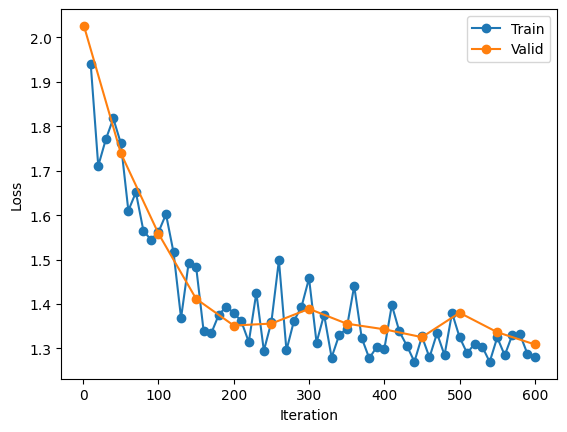

In [24]:
# Plot the iterations vs training/validation loss 
train_its, train_losses = zip(*metrics.train_losses)
val_its, val_losses = zip(*metrics.val_losses)
plt.plot(train_its, train_losses, '-o')
plt.plot(val_its, val_losses, '-o')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(['Train', "Valid"]);

In [25]:
# Fuse the model 
!mlx_lm.fuse --model {model_path}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading pretrained model
Fetching 11 files: 100%|████████████████████| 11/11 [00:00<00:00, 199728.76it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [26]:
# Load the fused model 
model, tokenizer = load("lora_fused_model")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
# Prompt the fused model and check your output. 
response = generate(
    model,
    tokenizer,
    prompt=format_prompt(system_prompt, question),
    verbose=True,
    temp=0.0,
    max_tokens=256,
)

Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

## Instructions
You are a master in the field of the esoteric, occult, Reappropriated Goddess and Education. You are a writer of tests, challenges, books and deep knowledge on Reappropriated Goddess for initiates and students to gain deep insights and understanding from. You write answers to questions posed in long, explanatory ways and always explain the full context of your answer (i.e., related concepts, formulas, examples, or history), as well as the step-by-step thinking process you take to answer the challenges. Be rigorous and thorough, and summarize the key themes, ideas, and conclusions at the end.<|eot_id|><|start_header_id|>user<|end_header_id|>


## User
How to make scrambled eggs?<|eot_id|><|start_header_id|>assistant<|end_header_id|>



Title: The Art of Crafting Scrambled Eggs: A Journey of Culinary Alchemy

Introduction:
In the realm of culinary arts, the humble scrambled egg is a staple dish that has 